# **Non-English Article Analysis of an Institution**
## Exploring Publications in *OpenAlex*

This notebook analyzes the distribution and counts of non-English articles published by a selected institution.

#### What is analyzed
- The count of non-English articles for the institution.
- The most and least represented non-English languages in the institution’s research. 

#### Why is this analysis interesting
- Many institutions operate in multilingual environments. Understanding the language distribution reveals how non-English languages are represented in that institution.
- While English dominates scientific publishing, non-English articles are important for reaching local audiences.

#### What can be observed?
- For ETH Zürich as an example, we can observe an extreme dominance by English articles. ETH Zürich has published in total over 190'000 articles and only around 9'000 articles are non-English. (roughly 4.7%)
- Regarding non-English articles, we can see by far the highest count in German articles, which was expected since ETH Zürich is located in the German-speaking part of Switzerland.
- In the chart "least represented", we can observe a vast diversity of languages, which is impressive to see.

### Setup
#### Imports

In [11]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from language_abbreviations import languages
from open_colors import colors

#### Response Validation

In [2]:
def validate_response(response):
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Failed to fetch data. Status code for {response.url}: {response.status_code}")

## Analysis: Proportion of Articles attributed to languages other than English for a selected institution

### Step 1: Fetch Non-English Articles
Fetch non-English articles from OpenAlex API for a given institution ID

In [3]:
def fetch_non_english_articles(institution_id, per_page=200):
    all_articles = []
    cursor = None  # Start with no cursor
    
    while True:
        url = f"https://api.openalex.org/works?filter=authorships.institutions.lineage:{institution_id},language:!languages/en&per_page={per_page}"
        if cursor:
            url += f"&cursor={cursor}"  # Append cursor if available
        response = requests.get(url)
        data = validate_response(response)
        
        if "results" not in data:
            break  # Stop if no results
        
        all_articles.extend(data["results"])
        
        # Check for next cursor in meta
        meta = data.get("meta", {})
        cursor = meta.get("next_cursor")
        if not cursor:
            break  # No more pages
    
    return all_articles

### Step 2: Process Articles
Count Non-English Articles Per Language

In [14]:
def process_articles(articles):
    df = pd.DataFrame([
        {"id": work["id"], "language": work.get("language")}
        for work in articles if work.get("language")
    ])
    
    return df.groupby("language").size().reset_index(name="total_count")

### Step 3: Fetch Total Articles by Language

In [5]:
def fetch_total_articles_by_language(institution_id):
    url = f"https://api.openalex.org/works?filter=authorships.institutions.lineage:{institution_id}&group_by=language"
    response = requests.get(url)
    data = validate_response(response)

    return {item["key"]: item["count"] for item in data.get("group_by", [])}

### Step 4: Visualizations – Plot Counts
#### Visualization 1: Bar chart with languages on x-axis and counts on y-axis.

In [6]:
def plot_count(language_counts):
    # Convert 'language' to string to handle floats/NaN properly
    language_counts["language"] = language_counts["language"].astype(str)
    
    # Map abbreviations to full names based on language_abbreviations.py
    language_counts["full_language"] = language_counts["language"].map(languages)
    
    # Sort the data by non_english_count descending
    language_counts_sorted = language_counts.sort_values(by="total_count", ascending=False)
    
    fig, ax = plt.subplots(figsize=(12, 6)) 
    ax.bar(language_counts_sorted["full_language"], language_counts_sorted["total_count"], color=colors["blue"][9]) 
    
    # Add labels and title
    ax.set_xlabel("Language")
    ax.set_ylabel("Count of Non-English Articles")
    ax.set_title("Count of Non-English Articles by Language at ETH Zürich")
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    
    # Set x-ticks to the number of languages
    ax.set_xticks(range(len(language_counts_sorted))) 
    # Rotate x-tick labels for better readability, handling NaN by filling with 'Unknown'
    ax.set_xticklabels(language_counts_sorted["full_language"].fillna("Unknown"), rotation=40, ha="right") 
    
    plt.tight_layout()
    plt.show()

In [7]:
def plot_count(language_counts):
    # Convert 'language' to string to handle floats/NaN properly
    language_counts["language"] = language_counts["language"].astype(str)
    
    # Map abbreviations to full names based on language_abbreviations.py
    language_counts["full_language"] = language_counts["language"].map(languages).fillna("Unknown")
    
    # Sort the data by total_count descending
    language_counts_sorted = language_counts.sort_values(by="total_count", ascending=False)
    
    fig, ax = plt.subplots(figsize=(10, 8)) 
    ax.barh(language_counts_sorted["full_language"], language_counts_sorted["total_count"], color=colors["blue"][9]) 
    
    # Add labels and title
    ax.set_ylabel("Language")
    ax.set_xlabel("Count of Non-English Articles")
    ax.set_title("Count of Non-English Articles by Language at ETH Zürich")
    ax.grid(axis="x", linestyle="--", alpha=0.7)
    
    plt.tight_layout()
    plt.show()

#### Visualization 2: Only display "most represented languages"
"Most represented languages" meaning languages with counts above a threshold, here we set 30.

In [8]:
def plot_most_represented(language_counts):
    # Map abbreviations to full names based on language_abbreviations.py
    language_counts["full_language"] = language_counts["language"].astype(str).map(languages).fillna("Unknown")
    
    # Sort the data by total_count descending
    language_counts_sorted = language_counts.sort_values(by="total_count", ascending=True)
    
    # Filter the data: only counts >= 30
    filtered = language_counts_sorted[language_counts_sorted["total_count"] >= 30]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(filtered["full_language"], filtered["total_count"], color=colors["blue"][9])
    
    # Add labels and title
    ax.set_ylabel("Language")
    ax.set_xlabel("Count of Non-English Articles")
    ax.set_title("Most Represented Non-English Languages at ETH Zürich (Count ≥ 30)")
    ax.grid(axis="x", linestyle="--", alpha=0.7)
    
    plt.tight_layout()
    plt.show()


#### Visualization 3: Only display "least represented languages"
"Least represented languages" meaning languages with counts below a threshold, here we set 30.

In [9]:
def plot_least_represented(language_counts, threshold=30):
    # Map abbreviations to full names based on language_abbreviations.py
    language_counts["full_language"] = language_counts["language"].astype(str).map(languages).fillna("Unknown")
    
    # Sort the data by total_count descending
    language_counts_sorted = language_counts.sort_values(by="total_count", ascending=True)
    
    # Filter the data: only counts < threshold
    filtered = language_counts_sorted[language_counts_sorted["total_count"] < threshold]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(filtered["full_language"], filtered["total_count"], color=colors["blue"][9])
    
    # Add labels and title
    ax.set_ylabel("Language")
    ax.set_xlabel("Count of Non-English Articles")
    ax.set_title(f"Least Represented Non-English Languages at ETH Zürich (Count < {threshold})")
    ax.grid(axis="x", linestyle="--", alpha=0.7)
    
    plt.tight_layout()
    plt.show()

### Step 5: Input Institution ID and Function Calls
If you wish to try for another institution, just replace the `institution_id` with the ID of your institution.

In [12]:
institution_id = "i35440088"  # ETH Zürich Example
articles = fetch_non_english_articles(institution_id)
language_counts = process_articles(articles)
total_counts = fetch_total_articles_by_language(institution_id)

### Step 6: Cleanup and Display Language Counts
Clean data for display of data and plotting.

In [15]:
# Convert full OpenAlex URLs to just language codes
cleaned_total_counts = {key.split("/")[-1]: value for key, value in total_counts.items()}
# Debugging: Print cleaned keys
print("Cleaned total_counts keys:", cleaned_total_counts.keys())
# Assign total counts correctly
language_counts["total_count"] = language_counts["language"].apply(lambda x: cleaned_total_counts.get(x, 0))
# Remove rows where total_count is 0
language_counts = language_counts[language_counts["total_count"] > 0]
# Debugging: Check final data before plotting
print("Final Data to Plot:")
language_counts

Cleaned total_counts keys: dict_keys(['en', 'de', 'lv', 'fr', 'es', 'he', 'it', 'ru', 'zh', 'fi', 'pt', 'nl', 'pl', 'fa', 'yi', 'hu', 'sv', 'ceb', 'ca', 'eo', 'ar', 'id', 'ja', 'no', 'tt', 'cs', 'la', 'uk', 'el', 'lt', 'sl', 'gl', 'hi', 'bn', 'et', 'hr', 'tr', 'als', 'bg', 'da', 'kn', 'ro', 'ta', 'th', 'tl', 'vi', 'af', 'az', 'br', 'ckb', 'cy', 'eu', 'gv', 'kk', 'ko', 'mr', 'sh', 'si', 'sr', 'su', 'tk', 'uz'])
Final Data to Plot:


,language,non_english_count,total_count
0,de,46,6932
1,es,4,161
2,fa,1,17
3,fr,9,550
4,he,12,56
5,hr,1,3
6,it,3,55
7,la,1,6
8,lv,117,1397
9,nl,1,23


Note:
- `non_english_count` comes from fetching and grouping only the non-English articles authored by that institution.
- `total_count` comes from a separate API query that groups all articles (English and non-English) by language for the same institution.

**Data sorted by Popularity**

In [16]:
# Sort language_counts by non_english_count descending (popularity)
language_counts_sorted = language_counts.sort_values(by="total_count", ascending=False)

# Display the table
language_counts_sorted

,language,non_english_count,total_count
0,de,46,6932
8,lv,117,1397
3,fr,9,550
1,es,4,161
4,he,12,56
6,it,3,55
9,nl,1,23
11,pl,1,20
2,fa,1,17
13,yi,1,16


### Step 7: Display Visualizations

In [17]:
sum(language_counts["total_count"])

9244

#### Plot 2: Most Represented Languages

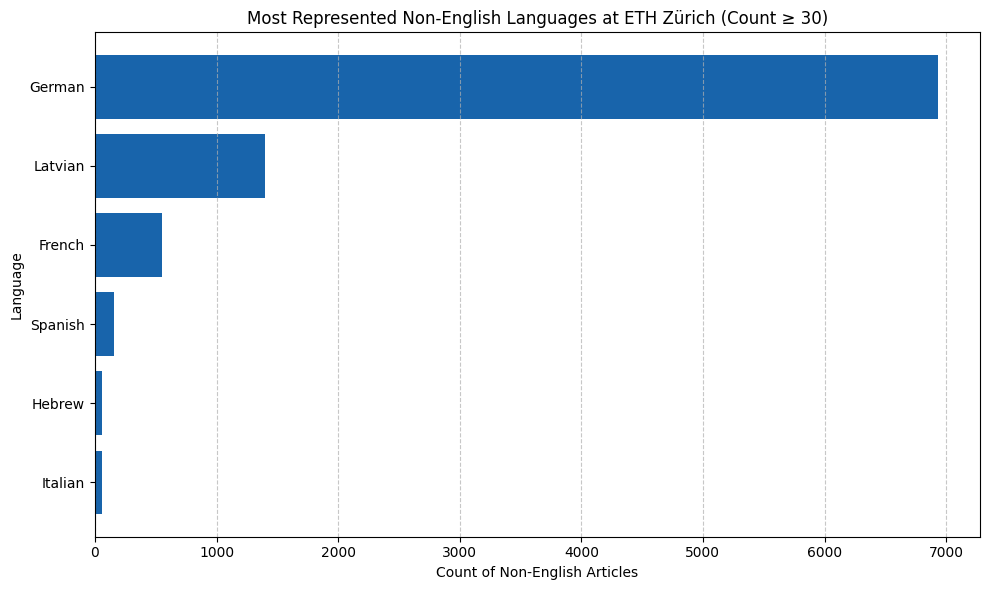

In [18]:
plot_most_represented(language_counts)

#### Plot 3: Least Represented Languages

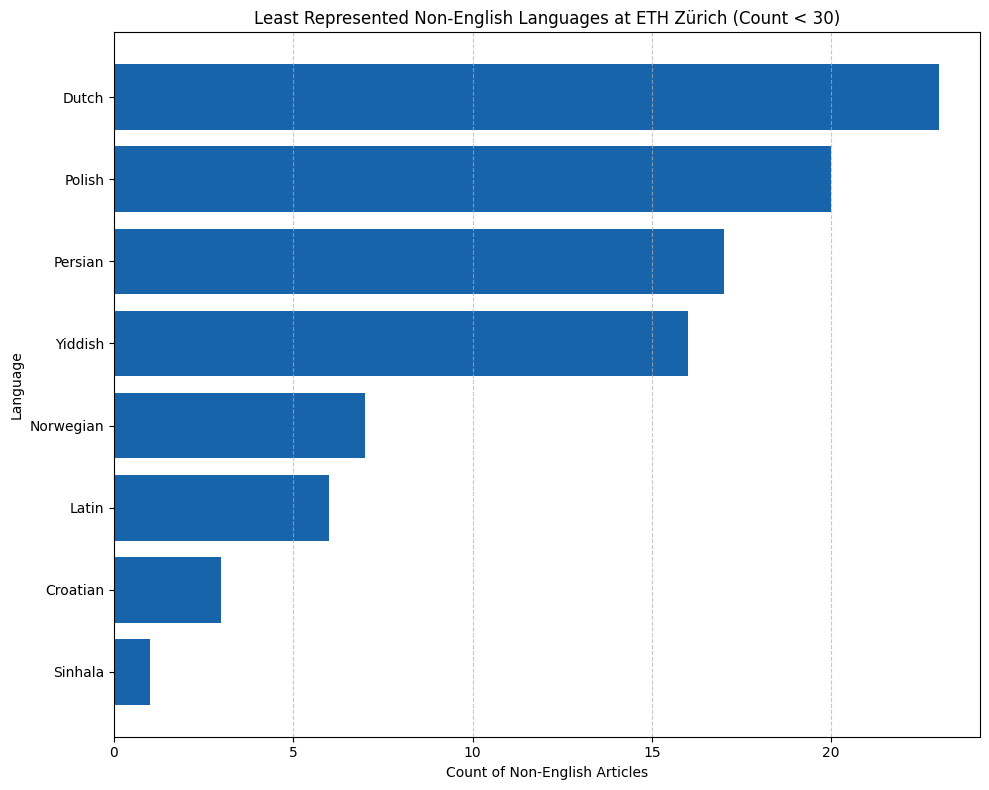

In [ ]:
plot_least_represented(language_counts, threshold=30)